Epoch 1/100
154/154 [==============================] - 17s 104ms/step - loss: 3.3597 - accuracy: 0.1528 - val_loss: 4.8242 - val_accuracy: 0.0273 - lr: 0.0010
Epoch 2/100
154/154 [==============================] - 16s 100ms/step - loss: 2.9364 - accuracy: 0.2222 - val_loss: 6.5541 - val_accuracy: 0.0369 - lr: 0.0010
Epoch 3/100
154/154 [==============================] - 34s 223ms/step - loss: 2.7383 - accuracy: 0.2669 - val_loss: 4.3737 - val_accuracy: 0.1149 - lr: 0.0010
Epoch 4/100
154/154 [==============================] - 33s 212ms/step - loss: 2.6154 - accuracy: 0.2922 - val_loss: 2.4186 - val_accuracy: 0.3269 - lr: 0.0010
Epoch 5/100
154/154 [==============================] - 35s 223ms/step - loss: 2.4981 - accuracy: 0.3205 - val_loss: 2.3881 - val_accuracy: 0.3606 - lr: 0.0010
Epoch 6/100
154/154 [==============================] - 33s 216ms/step - loss: 2.4148 - accuracy: 0.3408 - val_loss: 2.4308 - val_accuracy: 0.3641 - lr: 0.0010
Epoch 7/100
154/154 [=========================

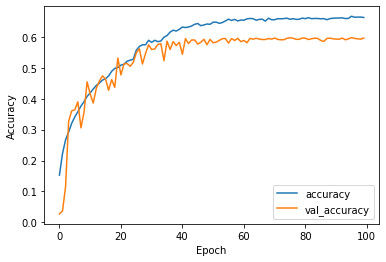

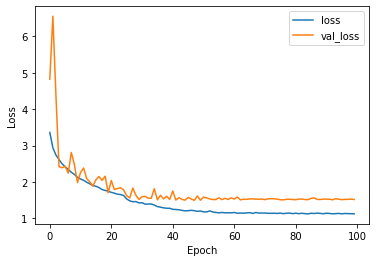

154/154 [==============================] - 1s 6ms/step


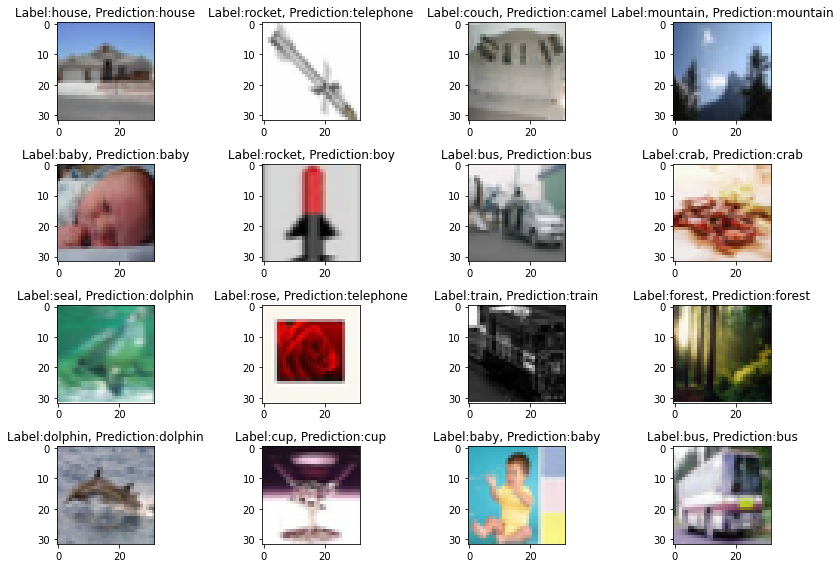

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import random

# 클래스 순서를 읽어들이기
class_file_path = 'C:/Users/JY/Desktop/딥러닝/fine_label_names_shuffle.txt'

# 파일 경로가 올바른지 확인
if not os.path.exists(class_file_path):
    print(f"Error: {class_file_path} 파일이 존재하지 않습니다.")
else:
    class_dict = {}
    with open(class_file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            class_number = int(parts[0].split('= ')[1])
            class_name = parts[1].split('= ')[1]
            class_dict[class_name] = class_number

    num_classes = len(class_dict)
    CIFAR100_CLASSES = list(class_dict.keys())

    def load_images_from_folder(folder, class_dict):
        images = []
        labels = []
        for filename in os.listdir(folder):
            if filename.endswith('.png'):
                img_path = os.path.join(folder, filename)
                img = load_img(img_path, target_size=(32, 32))
                img_array = img_to_array(img) / 255.0

                class_name = filename.split('_')[1].split('.')[0]
                class_number = class_dict.get(class_name)
                if class_number is not None:
                    images.append(img_array)
                    labels.append(class_number)

        return np.array(images), np.array(labels)

    train_folder = 'C:/Users/JY/Desktop/딥러닝/train'
    test_folder = 'C:/Users/JY/Desktop/딥러닝/test'

    x_train, y_train = load_images_from_folder(train_folder, class_dict)
    x_test, y_test = load_images_from_folder(test_folder, class_dict)

    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # 모델 구성
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # 추가된 층
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))  # 최적의 드롭아웃 비율
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # 학습률 스케줄링 설정
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=128),
        validation_data=(x_val, y_val),
        epochs=100,
        callbacks=[lr_reduction],
        verbose=1
    )

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 재연성을 위하여 랜덤시드 고정
    random.seed('intel')

    # TEST 데이터 예측하기
    predicted_result = model.predict(x_test)
    predicted_labels = np.argmax(predicted_result, axis=1)

    # random 함수를 통해서 임의의 16개 데이터 가져오기
    samples = random.choices(population=range(len(x_test)), k=16)

    # CIFAR100를 그릴 Figure 준비
    plt.figure(figsize=(12, 8))

    # 16개의 이미지 시각화
    for count, n in enumerate(samples, start=1):
        plt.subplot(4, 4, count)
        plt.imshow(x_test[n], interpolation='nearest')
        label = "Label:" + CIFAR100_CLASSES[y_test[n]]
        pred = "Prediction:" + CIFAR100_CLASSES[predicted_labels[n]]
        plt.title(label + ', ' + pred)

    plt.tight_layout()
    plt.show()

Epoch 1/100
154/154 [==============================] - 70s 451ms/step - loss: 4.3876 - accuracy: 0.0454 - val_loss: 3.9156 - val_accuracy: 0.0214 - lr: 0.0010
Epoch 2/100
154/154 [==============================] - 88s 570ms/step - loss: 3.6279 - accuracy: 0.0852 - val_loss: 3.8731 - val_accuracy: 0.0322 - lr: 0.0010
Epoch 3/100
154/154 [==============================] - 78s 502ms/step - loss: 3.4628 - accuracy: 0.1110 - val_loss: 3.5016 - val_accuracy: 0.1212 - lr: 0.0010
Epoch 4/100
154/154 [==============================] - 87s 564ms/step - loss: 3.3588 - accuracy: 0.1222 - val_loss: 3.1617 - val_accuracy: 0.1608 - lr: 0.0010
Epoch 5/100
154/154 [==============================] - 90s 585ms/step - loss: 3.2760 - accuracy: 0.1291 - val_loss: 3.0759 - val_accuracy: 0.1686 - lr: 0.0010
Epoch 6/100
154/154 [==============================] - 78s 509ms/step - loss: 3.2042 - accuracy: 0.1501 - val_loss: 3.0788 - val_accuracy: 0.1824 - lr: 0.0010
Epoch 7/100
154/154 [=========================

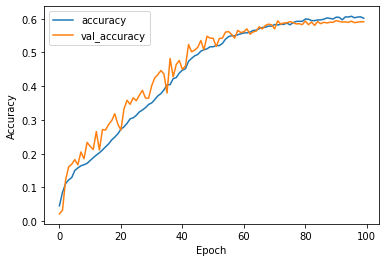

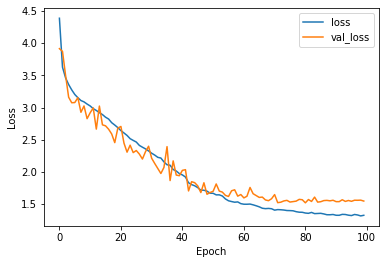

1/1 [==============================] - 0s 32ms/step


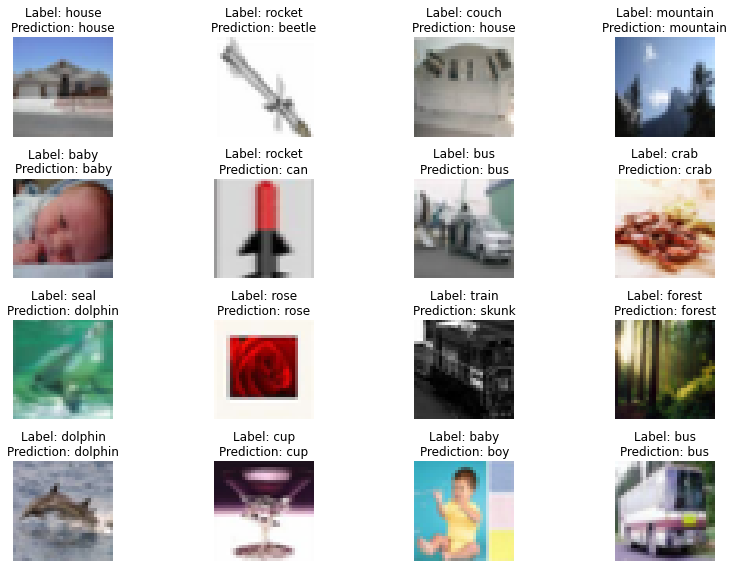

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, Input, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

class_file_path = 'C:/Users/JY/Desktop/딥러닝/fine_label_names_shuffle.txt'

if not os.path.exists(class_file_path):
    print(f"Error: {class_file_path} 파일이 존재하지 않습니다.")
else:
    class_dict = {}
    with open(class_file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            class_number = int(parts[0].split('= ')[1])
            class_name = parts[1].split('= ')[1]
            class_dict[class_name] = class_number

    num_classes = len(class_dict)

    def load_images_from_folder(folder, class_dict):
        images = []
        labels = []
        for filename in os.listdir(folder):
            if filename.endswith('.png'):
                img_path = os.path.join(folder, filename)
                img = load_img(img_path, target_size=(32, 32))
                img_array = img_to_array(img) / 255.0

                class_name = filename.split('_')[1].split('.')[0]
                class_number = class_dict.get(class_name)
                if class_number is not None:
                    images.append(img_array)
                    labels.append(class_number)

        return np.array(images), np.array(labels)

    train_folder = 'C:/Users/JY/Desktop/딥러닝/train'
    test_folder = 'C:/Users/JY/Desktop/딥러닝/test'

    x_train, y_train = load_images_from_folder(train_folder, class_dict)
    x_test, y_test = load_images_from_folder(test_folder, class_dict)

    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Residual block with skip connection
    def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
        y = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation(activation)(y)
        y = Conv2D(filters, kernel_size, padding='same')(y)
        y = BatchNormalization()(y)
        
        # Skip connection
        if strides != (1, 1) or x.shape[-1] != filters:
            x = Conv2D(filters, (1, 1), strides=strides, padding='same')(x)
        y = Add()([x, y])
        y = Activation(activation)(y)
        return y

    # 모델 구성
    input_layer = Input(shape=(32, 32, 3))
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Add residual blocks
    res_block1 = residual_block(pool1, 64)
    res_block2 = residual_block(res_block1, 128)

    flatten = Flatten()(res_block2)
    dense1 = Dense(256, activation='relu')(flatten)
    dropout = Dropout(0.2)(dense1)
    output_layer = Dense(num_classes, activation='softmax')(dropout)

    model = Model(inputs=input_layer, outputs=output_layer)

    # 학습률 스케줄링 설정
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=128),
        validation_data=(x_val, y_val),
        epochs=100,
        callbacks=[lr_reduction],
        verbose=1
    )

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 임의의 16개 데이터 가져오기
    random.seed('intel')
    samples = random.choices(range(len(x_test)), k=16)

    # CIFAR-100 클래스 정보
    CIFAR100_CLASSES = list(class_dict.keys())

    # 이미지 확인하기
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(samples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(x_test[idx])
        plt.title(f"Label: {CIFAR100_CLASSES[y_test[idx]]}\nPrediction: {CIFAR100_CLASSES[np.argmax(model.predict(x_test[idx].reshape(1, 32, 32, 3)))]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()